# Interactive apriltag detection

Requisites to run this notebook:
- apriltag C library compiled (see README.md)
- python scripts installed in `../python` (can change it manually in cell 4)
- mp4 video available in videofolder
- all results saved to `./data/` (excluded from version control)

In [425]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [468]:
#%matplotlib qt
%matplotlib inline

In [4]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import cv2  # Used to read images from video file

In [5]:
import sys
#pythondir="/Users/megret/Documents/Research/BeeTracking/Soft/apriltag/swatbotics-apriltag/python"
pythondir=os.path.join(os.getcwd(), '../python')
sys.path.append(pythondir)

In [25]:
import apriltagdetect as atd

options = atd.presets('tag25h5inv')
#options.quad_contours = False
options.nthreads=4
options.debug=0

det = atd.apriltag.Detector(options)

det.tag_detector.contents.qcp.contour_margin = 50
det.tag_detector.contents.qcp.min_side_length = 15

#det.tag_detector.contents.qtp.min_white_black_diff = 128

In Detector.__init__
0
Adding tag family "tag25h5"...


In [ ]:
# Use this only to download video from bigdbee server
# May take a while...

import requests
from math import floor
import getpass
def download_bigdbee_video(videoname,
                           baseurl="https://bigdbee.hpcf.upr.edu/webapp/data/videos/Gurabo",
                           auth=None, videofile=None):
    if (videofile is None):
        videofile = 'data/'+videoname
    
    url = baseurl+'/'+videoname
    #auth = ('user', 'password')
    print("Donwloading {} : ".format(url))
    if (auth is None):
        user = input("  Login: ")
        password = getpass.getpass('  Password: ')
        auth=(user,password)
    response = requests.get(url, auth=auth, stream=True)

    # Throw an error for bad status codes
    response.raise_for_status()
    
    def print_progress(x,xmax, step):
        if (floor((x) / step*10) < floor((x+1)/step*10)):
            print(".",end='')
        if (floor((x) / step) < floor((x+1)/step)):
            print("Downloaded {:.1f}%".format(x/xmax*100))

    print("Initiated download")
    total_length = int(response.headers['Content-length'])
    with open(videofile, 'wb') as handle:
        blocks = response.iter_content(1024)
        for i,block in enumerate(blocks):
            handle.write(block)
            print_progress(i,total_length/1024, total_length/1024/10)
 
# Uncomment to download
# download_bigdbee_video('C02_170622130000.mp4')
# download_bigdbee_video('tag25h5inv.zip',"https://bigdbee.hpcf.upr.edu/webapp/data/") # and unzip

In [ ]:
# Please customize video

videofolder='data/'
videoname = 'C02_170622120000.mp4'
videostem = videoname[:-4]
fps = 20

videofile = videofolder+'/'+videoname
vidcap = cv2.VideoCapture(videofile)

In [466]:
# Please customize input frame

from namedlist import namedlist
# hour, minute, second, frame within second (0..19)
# can also be 0,0,0,frame within video
HMSF = namedlist('HMSF', ['h', 'm', 's', 'f'])

#hmsf = HMSF(0, 15, 2, 0)  # New tags, small
#hmsf = HMSF(0, 24, 49, 0) # Old tags, small
#hmsf = HMSF(0, 20, 14, 0) # Old tags, large (but breaks vid capture)
#hmsf = HMSF(0, 20, 17, 0) # Empty frame (supposed to be old tags)
#hmsf = HMSF(0, 17, 18, 0) # New tags, large

#For C01_180724225145.mp4
hmsf = HMSF(0, 19, 10, 0) # New tags, bottom, move
hmsf = HMSF(0, 19, 3, 5) # New tags, top, move
hmsf = HMSF(0, 19, 24, 6) # Old tags, bottom, move
hmsf = HMSF(0, 19, 28, 6) # Old tags, top, move

#For C02_170622120000.mp4
#hmsf = HMSF(0, 3, 11, 0)
hmsf = HMSF(0, 0, 0, 8374)
#hmsf = HMSF(0, 0, 0, 9254) # Some wrongids

8374
True


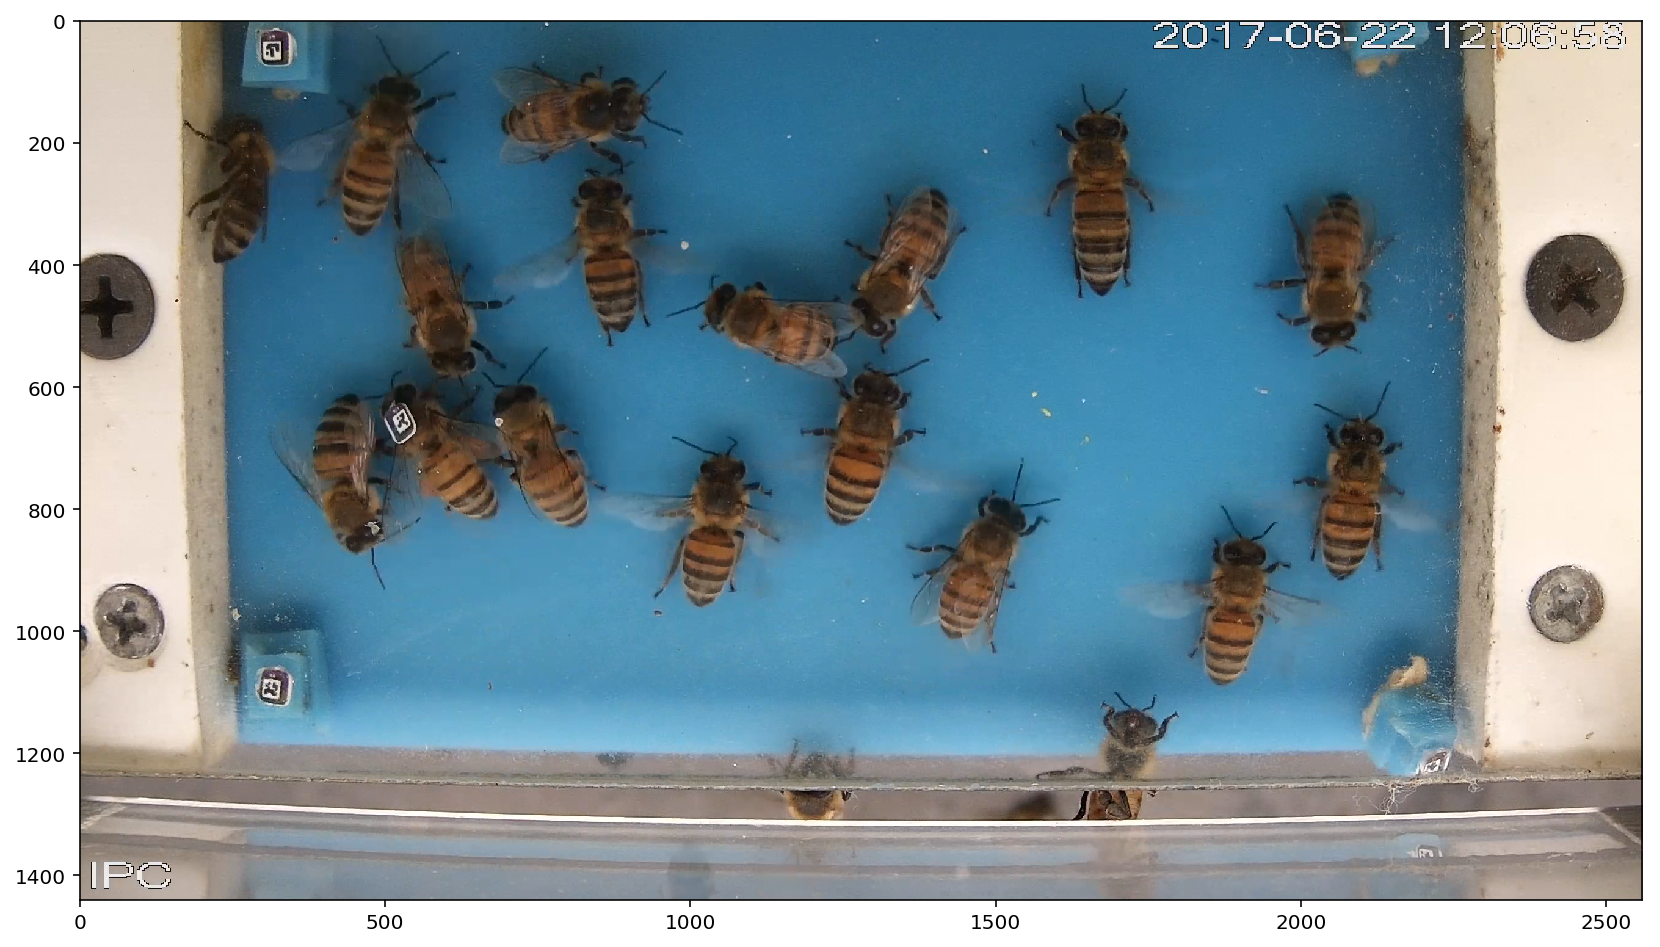

In [467]:
frame = (hmsf.h*3600+hmsf.m*60+hmsf.s)*fps+hmsf.f
print(frame)

vidcap.set(cv2.CAP_PROP_POS_MSEC,1000.0/fps*frame)
status,orig = vidcap.read();
print(status)

gray = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
rgb = cv2.cvtColor(orig, cv2.COLOR_RGB2BGR)

plt.figure(figsize=(14,10))
plt.imshow(rgb, cmap='gray')

In [469]:
os.makedirs('data/{}'.format(videostem),exist_ok=True)
cv2.imwrite('data/{}/frame{}.jpg'.format(videostem,frame), orig)

True

In [470]:
framedir='data/'+videostem
outdir='data/'+videostem+'-out'
tagsdir='data/'+videostem+'-tags'
os.makedirs(framedir,exist_ok=True)
os.makedirs(outdir,exist_ok=True)
os.makedirs(tagsdir,exist_ok=True)
for f in range(-15,15):
    # Convert HourMinuteSecondFrame to frame at 20Hz
    frame = (hmsf.h*3600+hmsf.m*60+hmsf.s)*fps+(hmsf.f+f)
    
    print("Frame {}...".format(frame))

    vidcap.set(cv2.CAP_PROP_POS_MSEC,1000.0/fps*frame)
    status,orig = vidcap.read();

    gray = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)
    #rgb = cv2.cvtColor(orig, cv2.COLOR_RGB2BGR)

    detections = det.detect(gray)
    tagextra = atd.do_extract_extras(detections, orig, 
                 flags={'tag_img':True,'rgb_mean':True},
                 n=5+4, pixsize=3)
    
    # Save input frame
    cv2.imwrite(framedir+'/frame-{}.jpg'.format(frame), orig)

    #plt.clf()
    #plt.imshow(orig)
    #atd.plot_detections(tags,plt.gca(), orig, labels=[round(tag.hamming,0) for tag in tags])
    #plt.savefig(outdir+'/outpdf-{}.pdf'.format(frame))

    # Save tags information
    tagjson = atd.Multiframejson(tagsdir+'/tags-{}.json'.format(frame))
    tagjson.open()
    tagjson.append(detections,frame,tagextra)
    tagjson.close()
    
    # Save image with detected tags
    tagimg = orig.copy()
    atd.draw_detections(tagimg, detections, draw_sampling=0)            
    cv2.imwrite(outdir+'/out-{}.png'.format(frame),tagimg)
print('Done')

Frame 8359...
Frame 8360...
Frame 8361...
Frame 8362...
Frame 8363...
Frame 8364...
Frame 8365...
Frame 8366...
Frame 8367...
Frame 8368...
Frame 8369...
Frame 8370...
Frame 8371...
Frame 8372...
Frame 8373...
Frame 8374...
Frame 8375...
Frame 8376...
Frame 8377...
Frame 8378...
Frame 8379...
Frame 8380...
Frame 8381...
Frame 8382...
Frame 8383...
Frame 8384...
Frame 8385...
Frame 8386...
Frame 8387...
Frame 8388...
Done


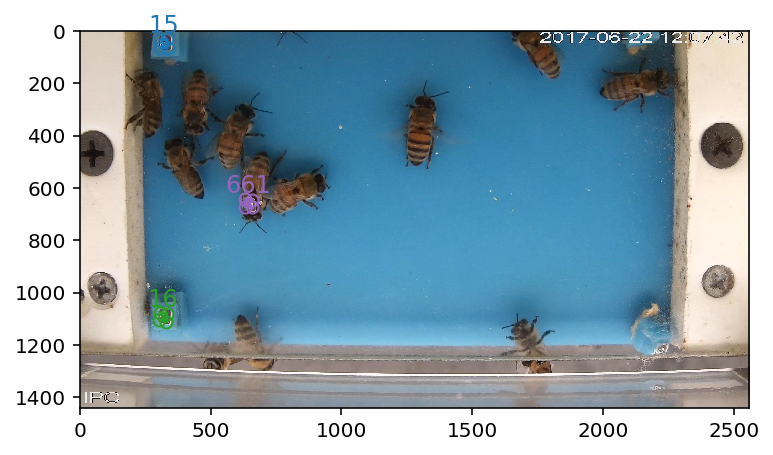

In [180]:
#%%timeit -r1
detections = det.detect(gray)

plt.imshow(gray, cmap='gray')
#atd.plot_detections(tags,plt.gca(), orig, labels=[round(tag.hamming,0) for tag in tags])
atd.plot_detections(detections,plt.gca(), orig)
#plt.savefig('data/'+videostem+'-out/'+'out-{}.pdf'.format(f))

In [277]:
# Convert detection list into tags list
# (with additional information)

tags=atd.detectionsToObj(detections)
S=60  # Size of fixed window round tag
for tag in tags:
    tag.pop('H')
    tag['tag_img'] = atd.extract_tag_image(tag['p'], rgb, pixsize=3)
    tag['tag_img0'] = atd.extract_tag_image(tag['p'], rgb,  rotate=False, S=S)    
    
tags[0].keys()

odict_keys(['family', 'id', 'hamming', 'goodness', 'decision_margin', 'c', 'p', 'tag_img', 'tag_img0'])

In [284]:
def plot_extracted_tag_images(tags, rgb):
    if (len(tags)==0): return

    if ('tag_img0' in tags[0]):
        rows=2
    else:
        rows=1
    
    fig,ax=plt.subplots(rows,len(tags), figsize=(len(tags)*2,4), squeeze=False)
    for k,tag in enumerate(tags):
        plt.sca(ax[0,k])
        plt.imshow(tag['tag_img'])
        plt.title(tag['id'])
        
        if (rows==2):
            plt.sca(ax[1,k])
            plt.imshow(tag['tag_img0'])
            P=np.array(tag['p'])-np.array(tag['c'])+S/2-0.5
            plt.plot(P[:,0],P[:,1],'+-')

    plt.tight_layout()
    return fig,ax

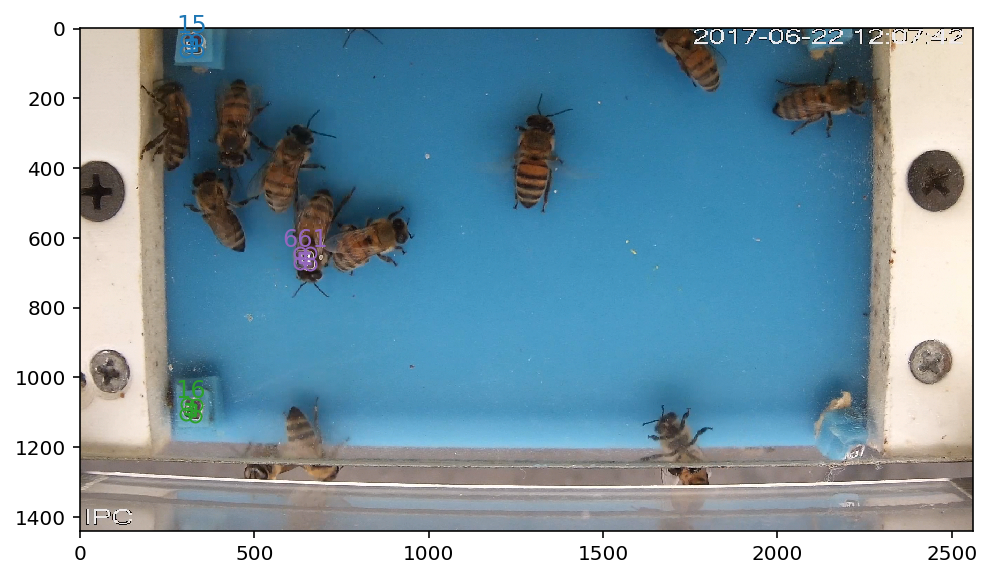

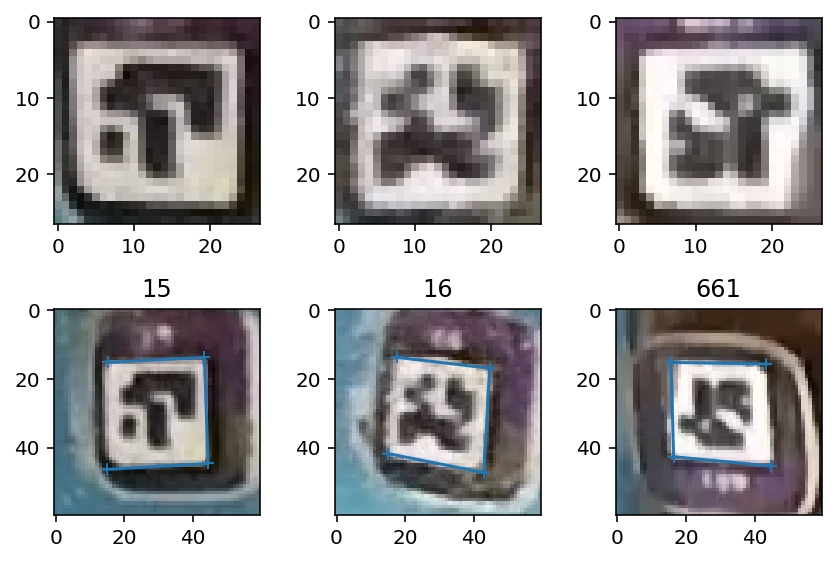

In [278]:
fig=plt.figure(figsize=(8,6))
plt.imshow(rgb)
atd.plot_detections(detections,plt.gca(), orig)

plot_extracted_tag_images(tags,rgb);

In [292]:
# Do the same from file 
# (extracted_tag works only if `tag_img` field was saved in the file)

import json

with open('data/C02_170622120000-tags/tags-9254.json','r') as fp:
    mftags = json.load(fp, object_pairs_hook=lambda a: OrderedDict(a))
mfdata = mftags['data']
frames = list(mfdata.keys())
tags2 = mfdata[frames[0]]['tags']  # Select only tags from first frame

for tag in tags2:
    tag['tag_img'] = atd.b64_to_img(tag['tag_img'])

In [293]:
tags2[0].keys()

odict_keys(['id', 'c', 'hamming', 'p', 'goodness', 'dm', 'rgb_mean', 'tag_img'])

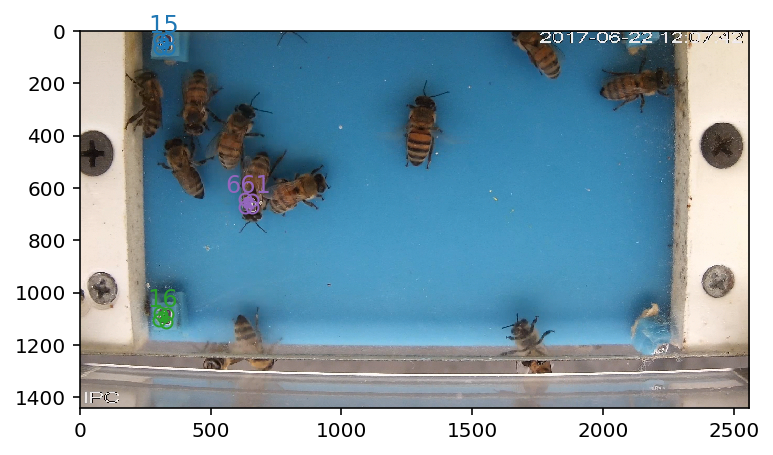

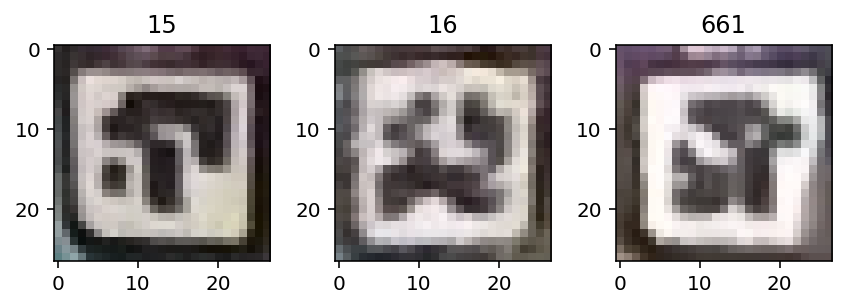

In [294]:
atd.plot_detections(tags2, plt.gca(), orig)

plot_extracted_tag_images(tags2,rgb);

In [19]:
# Close the video
vidcap.release()

In [298]:
# Extract tag images from json files and put them in a flat table
# (extracted_tag works only if `tag_img` field was saved in the file)

import json

tagimgs = []
for frame in range(9239,9269):
    print("{}...".format(frame))
    with open('data/C02_170622120000-tags/tags-{}.json'.format(frame),'r') as fp:
        mftags = json.load(fp, object_pairs_hook=lambda a: OrderedDict(a))
        mfdata = mftags['data']
        tags2 = mfdata[str(frame)]['tags']  # Select only tags from first frame
        for tag in tags2:
            tagimgs.append({'frame':frame, 'id':tag['id'], 'tagimg':atd.b64_to_img(tag['tag_img'])})


9239...
9240...
9241...
9242...
9243...
9244...
9245...
9246...
9247...
9248...
9249...
9250...
9251...
9252...
9253...
9254...
9255...
9256...
9257...
9258...
9259...
9260...
9261...
9262...
9263...
9264...
9265...
9266...
9267...
9268...


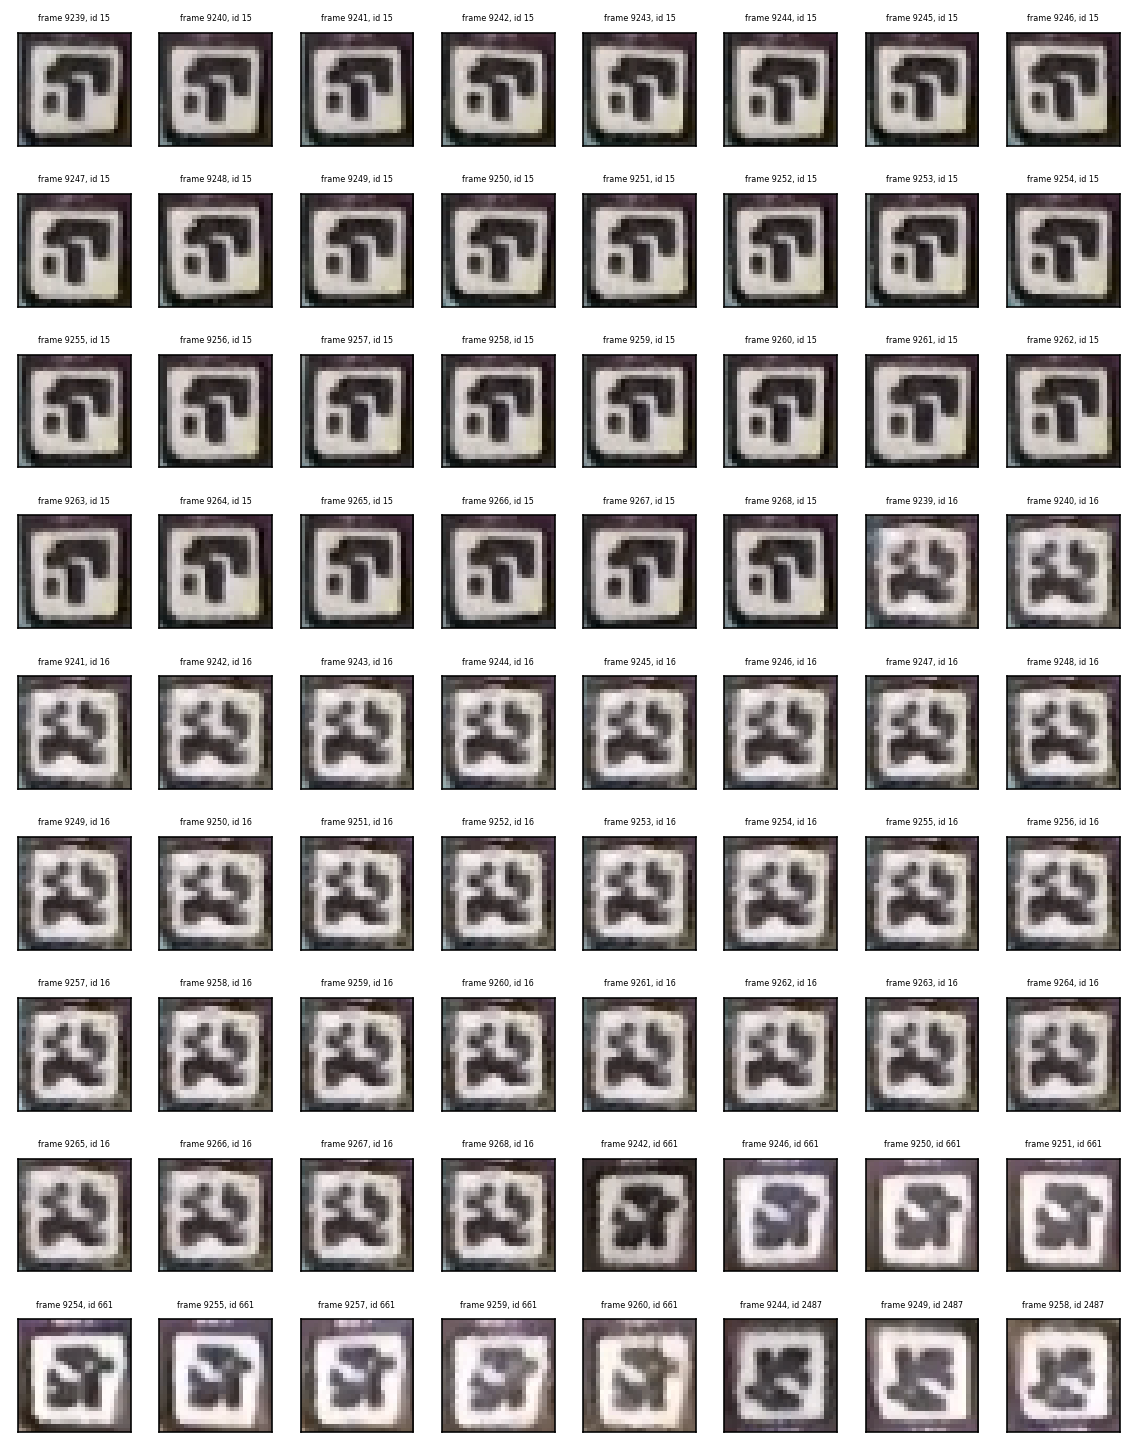

In [428]:
#tagf = [tag for tag in tagimgs if tag['id']==15]
tagf = tagimgs

tagf = sorted(tagf, key=lambda tag:tag['id'])

nx = math.floor(math.sqrt(len(tagf)))
ny = math.ceil(len(tagf)/nx)
fig,ax=plt.subplots(ny,nx, figsize=(1*nx,2*ny))
axf=ax.ravel()
for k,tag in enumerate(tagf):
    plt.sca(axf[k])
    plt.imshow(tag['tagimg'])
    plt.title('frame {}, id {}'.format(tag['frame'],tag['id']),
             {'fontsize': 4})
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()